In [6]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import pymesh
%matplotlib inline
plt.rcParams["figure.figsize"] = 12.8, 9.6

In [7]:
def plot_mesh(mesh):
    ax = plt.axes(projection='3d')
    x = mesh.vertices[:,0]
    y = mesh.vertices[:,1]
    z = mesh.vertices[:,2]
    triangles = mesh.faces[:]

    ax.plot_trisurf(x,z,triangles,y, shade=True, color='white')
    
    ax.set_ylim(-2,2)
    ax.set_xlim(-2, 2)
    ax.set_zlim(0,4)
    
    plt.show()
    
def resize_mesh(mesh, tol):
    """Takes mesh & resizes triangles to tol size"""
    mesh, __ = pymesh.remove_degenerated_triangles(mesh, 100);
    mesh, _info = pymesh.split_long_edges(mesh, tol)
    mesh, __ = pymesh.collapse_short_edges(mesh, 1e-6);
    mesh, _info = pymesh.collapse_short_edges(mesh, tol, preserve_feature=True)
    return mesh

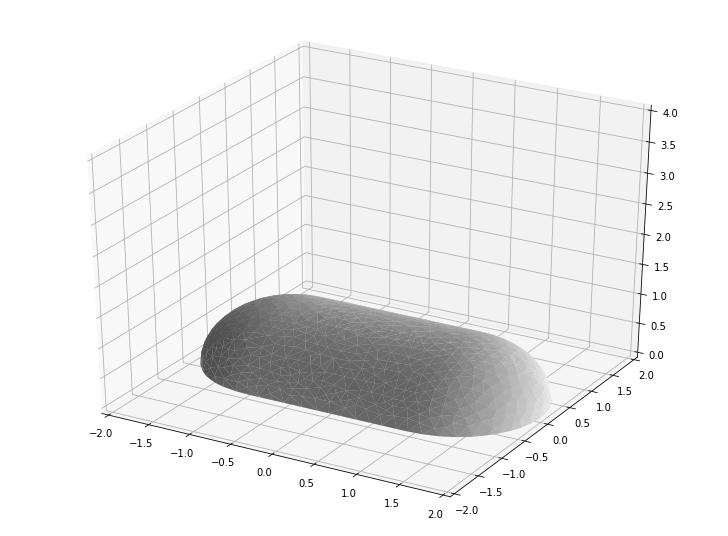

In [12]:
mesh = pymesh.load_mesh("sausage_shape.obj")

mesh = resize_mesh(mesh, 1e-1)

pymesh.save_mesh("regularised_cell.ply", mesh)

plot_mesh(mesh)

In [22]:
tetmesh = pymesh.tetrahedralize(mesh, 0.1)

In [23]:
dir(tetmesh)

['_Mesh__mesh',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_extra_info',
 'add_attribute',
 'attribute_names',
 'bbox',
 'boundary_edges',
 'boundary_loops',
 'boundary_vertices',
 'dim',
 'element_volumes',
 'elements',
 'enable_connectivity',
 'euler_characteristic',
 'faces',
 'genus',
 'get_attribute',
 'get_attribute_names',
 'get_face_adjacent_faces',
 'get_face_adjacent_voxels',
 'get_face_attribute',
 'get_vertex_adjacent_faces',
 'get_vertex_adjacent_vertices',
 'get_vertex_adjacent_voxels',
 'get_vertex_attribute',
 'get_voxel_adjacent_faces',
 'get_voxel_adjacent_voxels',
 'get_voxel_attribute',
 'has_attribute',
 'is_closed',
 'is_edge_manifold',
 'is

In [28]:
print(tetmesh.dim)

3
